# NNDL HW 2
## Amir Mohammad Ranjbar Pazoki 810199340
____________________________________________________________________________________________________________________________________________________________

## 1. MLP (Regression)

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
import time
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Dense, Input

### Read data

In [ ]:
housing_data_path = "/content/house prices.csv"
housing_data = pd.read_csv(housing_data_path)
housing_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Examine Dataset

In [ ]:
housing_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
print("Dataset Length: {}".format(len(housing_data)))
housing_data.info()

Dataset Length: 1460
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   

#### Explore columns and extract columns with meaningful nulls

In [ ]:
meaningful_null_columns = ["Alley", "MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
                           "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual",
                           "GarageCond", "PoolQC", "Fence", "MiscFeature"]

### Preprocess data
#### Replace meaningful nulls with "No"

In [ ]:
for column in meaningful_null_columns:
  housing_data[column] = housing_data[column].replace({np.nan: 'No'})
housing_data_nulls_count = housing_data.isna().sum().sort_values(ascending = False).head(10)
print("Columns nulls count:\n{}".format(housing_data_nulls_count))

Columns nulls count:
LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
Electrical       1
SalePrice        0
ExterCond        0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
dtype: int64


#### Calculate missing values percentage for each column

In [ ]:
column_missing_value_percentage = housing_data.isna().sum() / len(housing_data) * 100
column_missing_value_percentage.sort_values(ascending = False).head(10)

LotFrontage    17.739726
GarageYrBlt     5.547945
MasVnrArea      0.547945
Electrical      0.068493
SalePrice       0.000000
ExterCond       0.000000
RoofStyle       0.000000
RoofMatl        0.000000
Exterior1st     0.000000
Exterior2nd     0.000000
dtype: float64

#### Remove columns with more than 5% missing values

In [ ]:
housing_data.drop(columns=['LotFrontage', 'GarageYrBlt'], inplace=True)
housing_data_nulls_count = housing_data.isna().sum().sort_values(ascending = False).head(10)
print("Columns nulls count:\n{}".format(housing_data_nulls_count))

Columns nulls count:
MasVnrArea     8
Electrical     1
SalePrice      0
Foundation     0
RoofMatl       0
Exterior1st    0
Exterior2nd    0
MasVnrType     0
ExterQual      0
ExterCond      0
dtype: int64


#### Replace numerical missing values with median

In [ ]:
housing_data['MasVnrArea'] = housing_data['MasVnrArea'].fillna(housing_data['MasVnrArea'].median())
housing_data_nulls_count = housing_data.isna().sum().sort_values(ascending = False).head(10)
print("Columns nulls count:\n{}".format(housing_data_nulls_count))

Columns nulls count:
Electrical     1
SalePrice      0
Foundation     0
RoofMatl       0
Exterior1st    0
Exterior2nd    0
MasVnrType     0
MasVnrArea     0
ExterQual      0
ExterCond      0
dtype: int64


#### Replace categorical missing values with mode

In [ ]:
housing_data['Electrical'] = housing_data['Electrical'].fillna(housing_data['Electrical'].mode()[0])
housing_data_nulls_count = housing_data.isna().sum().sort_values(ascending = False).head(10)
print("Columns nulls count:\n{}".format(housing_data_nulls_count))

Columns nulls count:
SalePrice      0
Foundation     0
RoofMatl       0
Exterior1st    0
Exterior2nd    0
MasVnrType     0
MasVnrArea     0
ExterQual      0
ExterCond      0
BsmtQual       0
dtype: int64


#### Make target column in logaritmic form

In [ ]:
housing_data["SalePrice"] = np.log10(housing_data["SalePrice"])
housing_data

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,No,Attchd,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,No,No,No,0,2,2008,WD,Normal,5.319106
1,2,20,RL,9600,Pave,No,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,No,No,No,0,5,2007,WD,Normal,5.258877
2,3,60,RL,11250,Pave,No,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,No,No,No,0,9,2008,WD,Normal,5.349278
3,4,70,RL,9550,Pave,No,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,No,No,No,0,2,2006,WD,Abnorml,5.146128
4,5,60,RL,14260,Pave,No,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,No,No,No,0,12,2008,WD,Normal,5.397940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,No,No,No,0,8,2007,WD,Normal,5.243038
1456,1457,20,RL,13175,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,No,MnPrv,No,0,2,2010,WD,Normal,5.322219
1457,1458,70,RL,9042,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,No,GdPrv,Shed,2500,5,2010,WD,Normal,5.425697
1458,1459,20,RL,9717,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,No,Attchd,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,No,No,No,0,4,2010,WD,Normal,5.152670


#### Normalize numerical columns (Using mean normalization)

In [ ]:
numeric_columns = housing_data._get_numeric_data().columns
for column in numeric_columns:
  housing_data[column] = (housing_data[column]-housing_data[column].mean())/housing_data[column].std()
housing_data

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,-1.730272,0.073350,RL,-0.207071,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.651256,-0.517023,1.050634,0.878367,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.513928,Gd,TA,PConc,Gd,TA,No,GLQ,0.575228,Unf,-0.288554,-0.944267,-0.459145,GasA,Ex,Y,SBrkr,-0.793162,1.161454,-0.120201,0.370207,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,Gd,0.911897,Typ,-0.950901,No,Attchd,RFn,0.311618,0.350880,TA,TA,Y,-0.751918,0.216429,-0.359202,-0.116299,-0.270116,-0.068668,No,No,No,-0.087658,-1.598563,0.138730,WD,Normal,0.559876
1,-1.727900,-0.872264,RL,-0.091855,Pave,No,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,-0.071812,2.178881,0.156680,-0.429430,Gable,CompShg,MetalSd,MetalSd,None,-0.570555,TA,TA,CBlock,Gd,TA,Gd,ALQ,1.171591,Unf,-0.288554,-0.641008,0.466305,GasA,Ex,Y,SBrkr,0.257052,-0.794891,-0.120201,-0.482347,-0.819684,3.947457,0.789470,-0.761360,0.163723,-0.211381,TA,-0.318574,Typ,0.600289,TA,Attchd,RFn,0.311618,-0.060710,TA,TA,Y,1.625638,-0.704242,-0.359202,-0.116299,-0.270116,-0.068668,No,No,No,-0.087658,-0.488943,-0.614228,WD,Normal,0.212692
2,-1.725528,0.073350,RL,0.073455,Pave,No,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.651256,-0.517023,0.984415,0.829930,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.325803,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.092875,Unf,-0.288554,-0.301540,-0.313261,GasA,Ex,Y,SBrkr,-0.627611,1.188943,-0.120201,0.514836,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,Gd,-0.318574,Typ,0.600289,TA,Attchd,RFn,0.311618,0.631510,TA,TA,Y,-0.751918,-0.070337,-0.359202,-0.116299,-0.270116,-0.068668,No,No,No,-0.087658,0.990552,0.138730,WD,Normal,0.733795
3,-1.723156,0.309753,RL,-0.096864,Pave,No,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,0.651256,-0.517023,-1.862993,-0.720051,Gable,CompShg,Wd Sdng,Wd Shng,None,-0.570555,TA,TA,BrkTil,TA,Gd,No,ALQ,-0.499103,Unf,-0.288554,-0.061648,-0.687089,GasA,Gd,Y,SBrkr,-0.521555,0.936955,-0.120201,0.383528,1.107431,-0.240978,-1.025689,-0.761360,0.163723,-0.211381,Gd,0.296662,Typ,0.600289,Gd,Detchd,Unf,1.649742,0.790533,TA,TA,Y,-0.751918,-0.175988,4.091122,-0.116299,-0.270116,-0.068668,No,No,No,-0.087658,-1.598563,-1.367186,WD,Abnorml,-0.437232
4,-1.720785,0.073350,RL,0.375020,Pave,No,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,1.374324,-0.517023,0.951306,0.733056,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.366021,Gd,TA,PConc,Gd,TA,Av,GLQ,0.463410,Unf,-0.288554,-0.174805,0.199611,GasA,Ex,Y,SBrkr,-0.045596,1.617323,-0.120201,1.298881,1.107431,-0.240978,0.789470,1.227165,1.389547,-0.211381,Gd,1.527133,Typ,0.600289,TA,Attchd,RFn,1.649742,1.697903,TA,TA,Y,0.779930,0.563567,-0.359202,-0.116299,-0.270116,-0.068668,No,No,No,-0.087658,2.100173,0.138730,WD,Normal,1.014303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.720785,0.073350,RL,-0.260471,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,-0.071812,-0.517023,0.918196,0.733056,G

#### Make categorical variables one hot

In [ ]:
all_columns = housing_data.columns
numeric_columns = housing_data._get_numeric_data().columns
categorical_columns = list(set(all_columns) - set(numeric_columns))
encoder = OneHotEncoder(handle_unknown='ignore')
transformed_columns = encoder.fit_transform(
    housing_data[categorical_columns].to_numpy())
encoded_dataframe = pd.DataFrame(transformed_columns.toarray(), columns=encoder.get_feature_names())
housing_data = pd.concat([housing_data, encoded_dataframe], axis=1).drop(categorical_columns, axis=1)
housing_data

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,x0_Bnk,x0_HLS,x0_Low,x0_Lvl,...,x35_FuseF,x35_FuseP,x35_Mix,x35_SBrkr,x36_2Types,x36_Attchd,x36_Basment,x36_BuiltIn,x36_CarPort,x36_Detchd,x36_No,x37_Ex,x37_Fa,x37_Gd,x37_Po,x37_TA,x38_Floor,x38_GasA,x38_GasW,x38_Grav,x38_OthW,x38_Wall,x39_Corner,x39_CulDSac,x39_FR2,x39_FR3,x39_Inside,x40_Flat,x40_Gable,x40_Gambrel,x40_Hip,x40_Mansard,x40_Shed,x41_Fa,x41_Gd,x41_No,x41_Po,x41_TA,x42_AllPub,x42_NoSeWa
0,-1.730272,0.073350,-0.207071,0.651256,-0.517023,1.050634,0.878367,0.513928,0.575228,-0.288554,-0.944267,-0.459145,-0.793162,1.161454,-0.120201,0.370207,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,0.911897,-0.950901,0.311618,0.350880,-0.751918,0.216429,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,0.138730,0.559876,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-1.727900,-0.872264,-0.091855,-0.071812,2.178881,0.156680,-0.429430,-0.570555,1.171591,-0.288554,-0.641008,0.466305,0.257052,-0.794891,-0.120201,-0.482347,-0.819684,3.947457,0.789470,-0.761360,0.163723,-0.211381,-0.318574,0.600289,0.311618,-0.060710,1.625638,-0.704242,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-0.488943,-0.614228,0.212692,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-1.725528,0.073350,0.073455,0.651256,-0.517023,0.984415,0.829930,0.325803,0.092875,-0.288554,-0.301540,-0.313261,-0.627611,1.188943,-0.120201,0.514836,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,-0.318574,0.600289,0.311618,0.631510,-0.751918,-0.070337,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,0.990552,0.138730,0.733795,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-1.723156,0.309753,-0.096864,0.651256,-0.517023,-1.862993,-0.720051,-0.570555,-0.499103,-0.288554,-0.061648,-0.687089,-0.521555,0.936955,-0.120201,0.383528,1.107431,-0.240978,-1.025689,-0.761360,0.163723,-0.211381,0.296662,0.600289,1.649742,0.790533,-0.751918,-0.175988,4.091122,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,-1.367186,-0.437232,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-1.720785,0.073350,0.375020,1.374324,-0.517023,0.951306,0.733056,1.366021,0.463410,-0.288554,-0.174805,0.199611,-0.045596,1.617323,-0.120201,1.298881,1.107431,-0.240978,0.789470,1.227165,1.389547,-0.211381,1.527133,0.600289,1.649742,1.697903,0.779930,0.563567,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,2.100173,0.138730,1.014303,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.720785,0.073350,-0.260471,-0.071812,-0.517023,0.918196,0.733056,-0.570555,-0.972685,-0.288554,0.873022,-0.238040,-0.542249,0.794925,-0.120201,0.250316,-0.819684,-0.240978,0.789470,1.227165,0.163723,-0.211381,0.296662,0.600289,0.311618,-0.060710,-0.75191

#### Remove id column

In [ ]:
housing_data.drop(columns=["Id"], inplace=True)
housing_data

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,x0_Bnk,x0_HLS,x0_Low,x0_Lvl,x1_Gtl,...,x35_FuseF,x35_FuseP,x35_Mix,x35_SBrkr,x36_2Types,x36_Attchd,x36_Basment,x36_BuiltIn,x36_CarPort,x36_Detchd,x36_No,x37_Ex,x37_Fa,x37_Gd,x37_Po,x37_TA,x38_Floor,x38_GasA,x38_GasW,x38_Grav,x38_OthW,x38_Wall,x39_Corner,x39_CulDSac,x39_FR2,x39_FR3,x39_Inside,x40_Flat,x40_Gable,x40_Gambrel,x40_Hip,x40_Mansard,x40_Shed,x41_Fa,x41_Gd,x41_No,x41_Po,x41_TA,x42_AllPub,x42_NoSeWa
0,0.073350,-0.207071,0.651256,-0.517023,1.050634,0.878367,0.513928,0.575228,-0.288554,-0.944267,-0.459145,-0.793162,1.161454,-0.120201,0.370207,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,0.911897,-0.950901,0.311618,0.350880,-0.751918,0.216429,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,0.138730,0.559876,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.872264,-0.091855,-0.071812,2.178881,0.156680,-0.429430,-0.570555,1.171591,-0.288554,-0.641008,0.466305,0.257052,-0.794891,-0.120201,-0.482347,-0.819684,3.947457,0.789470,-0.761360,0.163723,-0.211381,-0.318574,0.600289,0.311618,-0.060710,1.625638,-0.704242,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-0.488943,-0.614228,0.212692,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.073350,0.073455,0.651256,-0.517023,0.984415,0.829930,0.325803,0.092875,-0.288554,-0.301540,-0.313261,-0.627611,1.188943,-0.120201,0.514836,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,-0.318574,0.600289,0.311618,0.631510,-0.751918,-0.070337,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,0.990552,0.138730,0.733795,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.309753,-0.096864,0.651256,-0.517023,-1.862993,-0.720051,-0.570555,-0.499103,-0.288554,-0.061648,-0.687089,-0.521555,0.936955,-0.120201,0.383528,1.107431,-0.240978,-1.025689,-0.761360,0.163723,-0.211381,0.296662,0.600289,1.649742,0.790533,-0.751918,-0.175988,4.091122,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,-1.367186,-0.437232,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.073350,0.375020,1.374324,-0.517023,0.951306,0.733056,1.366021,0.463410,-0.288554,-0.174805,0.199611,-0.045596,1.617323,-0.120201,1.298881,1.107431,-0.240978,0.789470,1.227165,1.389547,-0.211381,1.527133,0.600289,1.649742,1.697903,0.779930,0.563567,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,2.100173,0.138730,1.014303,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.073350,-0.260471,-0.071812,-0.517023,0.918196,0.733056,-0.570555,-0.972685,-0.288554,0.873022,-0.238040,-0.542249,0.794925,-0.120201,0.250316,-0.819684,-0.240978,0.789470,1.227165,0.163723,-0.211381,0.296662,0.600289,0.311618,-0.060710,-0.751918,-0.100523,-0.359202,-0.116299,-0.

### Train-Test Split

In [ ]:
def get_train_test_loaders(dataset, target_column, train_percentage=0.8, batch_size=128):
  target_tensor = torch.tensor(dataset[target_column].values)
  features_tensor = torch.tensor(dataset.drop(target_column, axis=1).values)
  tensor_dataset = torch.utils.data.TensorDataset(features_tensor, target_tensor)
  train_size = int(train_percentage * len(dataset))
  test_size = len(dataset) - train_size
  train_set, test_set = torch.utils.data.random_split(tensor_datasetش, [train_size, test_size])
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
  return train_loader, test_loader

### Define and Implement Network

In [ ]:
class Net(nn.Module):
  def __init__(self, layer_sizes, activation_function):
    super().__init__()
    self.layers = nn.ModuleList()
    for layer_number in range(len(layer_sizes)-1):
      self.layers.append(nn.Linear(layer_sizes[layer_number], layer_sizes[layer_number+1]))
    self.activation_function = activation_function
    # self.logsoftmax = nn.LogSoftmax(dim=1)
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, input):
    input = input.view(input.shape[0], -1)
    for layer_number in range(len(self.layers)-1):
      inactive_layer_output = self.layers[layer_number](input)
      activated_output = self.activation_function(inactive_layer_output)
      input = self.dropout(activated_output)
    
    output = self.layers[-1](input)
    # output = self.logsoftmax(last_layer_output)

    return output.squeeze()

### Test Network

In [ ]:
def test(model, test_set, loss_function, other_metric):
  with torch.no_grad():
    batches_test_loss = []
    batches_test_metric = []
    for features, target in test_set:
      output = model(features.float())
      loss = loss_function(output, target.float()).item()
      batches_test_loss.append(loss)
      metric = other_metric(output, target.float()).item()
      batches_test_metric.append(metric)
  return np.mean(batches_test_loss), np.mean(batches_test_metric)

### Get test predicted and real values

In [ ]:
def get_predicted_and_real_test(model, test_set):
  with torch.no_grad():
    predicted_values = np.array([])
    target_values = np.array([])
    for features, target in test_set:
      predicted = model(features.float())
      predicted_values = np.append(predicted_values, predicted)
      target_values = np.append(target_values, target)
    return predicted_values, target_values

### Train Network

In [ ]:
def train_and_test(model, train_set, test_set, epochs_num, optimizer, loss_function,
                   other_metric):
  epochs_train_loss = []
  epochs_train_metric = []
  epochs_test_loss = []
  epochs_test_metric = []
  for epoch in range(epochs_num):
    batches_train_loss = []
    batches_train_metric = []
    for features, targets in train_set:
      optimizer.zero_grad()
      output = model(features.float())
      loss = loss_function(output, targets.float())
      loss.backward()
      optimizer.step()
      batches_train_loss.append(loss.item())
      with torch.no_grad():
        metric = other_metric(output, targets.float())
        batches_train_metric.append(metric.item())
    epochs_train_loss.append(np.mean(batches_train_loss))
    epochs_train_metric.append(np.mean(batches_train_metric))
    test_loss, test_metric = test(model, test_set, loss_function, other_metric)
    epochs_test_loss.append(test_loss)
    epochs_test_metric.append(test_metric)
    predicted_values, target_values = get_predicted_and_real_test(model, test_set)
  return epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metric, \
           predicted_values, target_values

### Plot losses function

In [ ]:
def plot_losses(epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic,
                epochs_num, loss_type, metric):
  fig, (ax1, ax2) = plt.subplots(2)
  fig.set_figheight(10)
  fig.set_figwidth(15)
  fig.tight_layout(pad=3)
  x_axis = range(1, epochs_num+1)
  legends = ['train', 'test']
  x_label = 'Epoch'
  ax1.plot(x_axis, epochs_train_loss, epochs_test_loss)
  ax1.set_title(loss_type)
  ax1.set_xlabel(x_label)
  ax1.legend(legends)
  ax2.plot(x_axis, epochs_train_metric, epochs_test_metic)
  ax2.set_title(metric)
  ax2.set_xlabel(x_label)
  ax2.legend(legends)
  fig.show()
  plt.show()

### Plot predicitons versus real values function

In [ ]:
def plot_pred_vs_target(predicted_values, target_values):
  plt.title('Predictions vs. Target prices')
  plt.scatter(target_values, predicted_values)
  plt.xlabel('Reals')
  plt.ylabel('Predictions')
  plt.show()

### Train & Test with 8 layers and ReLU activation function

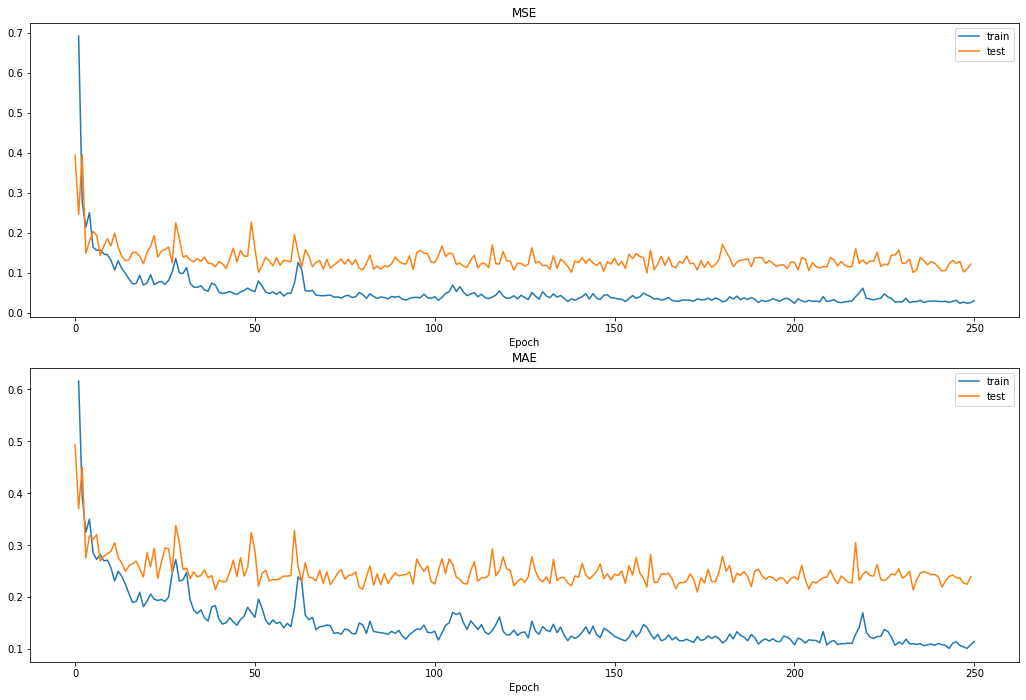

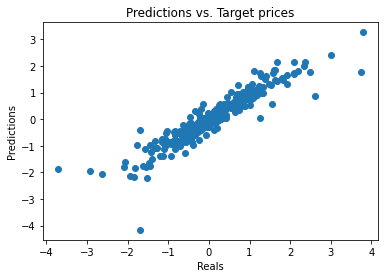

In [ ]:
epochs_num = 250
target_column = "SalePrice"
train_loader, test_loader = get_train_test_loaders(housing_data, target_column)
feature_size = housing_data.shape[1]-1
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.ReLU()
base_model = Net(layer_sizes, activation_function)
optimizer = optim.Adam(base_model.parameters(), lr=0.002)
loss_function = nn.MSELoss()
other_metric = nn.L1Loss()
epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic, predicted_values, target_values = train_and_test(
    base_model, train_loader, test_loader, 
    epochs_num, optimizer, loss_function,
    other_metric)
plot_losses(epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic,
            epochs_num, "MSE", "MAE")
plot_pred_vs_target(predicted_values, target_values)

### Train & Test with 5 layers

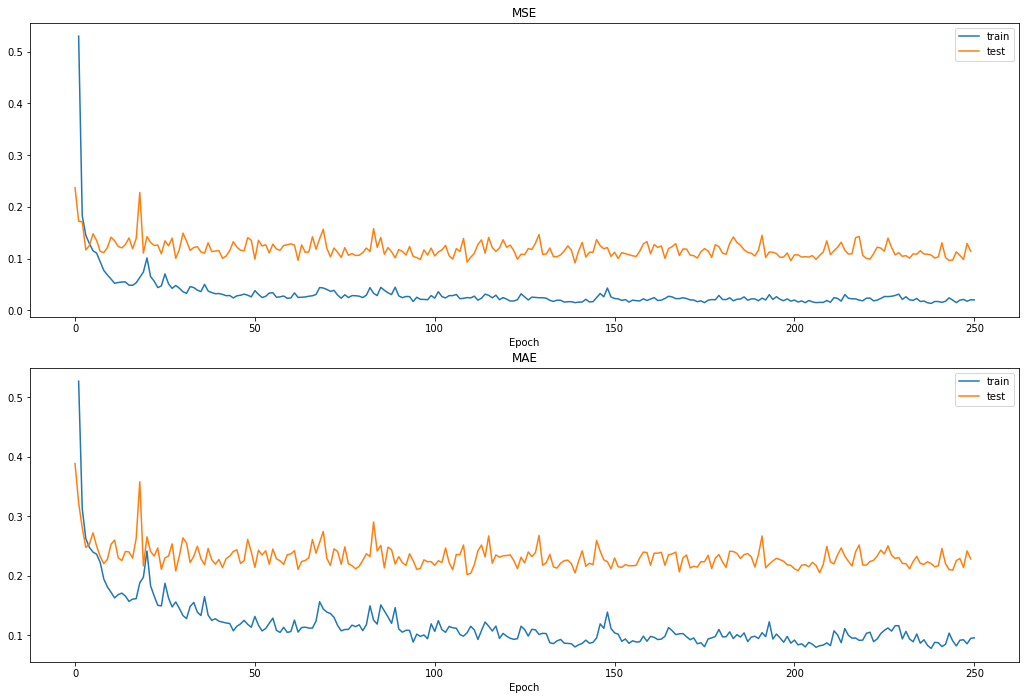

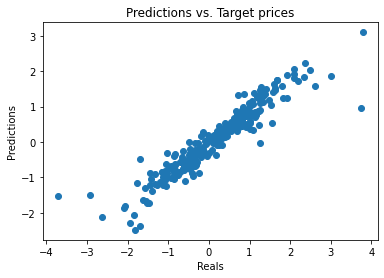

In [ ]:
layer_sizes = [feature_size, 512, 128, 32, 1]
activation_function = nn.ReLU()
second_model = Net(layer_sizes, activation_function)
optimizer = optim.Adam(second_model.parameters(), lr=0.002)
loss_function = nn.MSELoss()
other_metric = nn.L1Loss()
epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic, predicted_values, target_values = train_and_test(
    second_model, train_loader, test_loader, 
    epochs_num, optimizer, loss_function,
    other_metric)
plot_losses(epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic,
            epochs_num, "MSE", "MAE")
plot_pred_vs_target(predicted_values, target_values)

### Train & Test with Sigmoid activation function

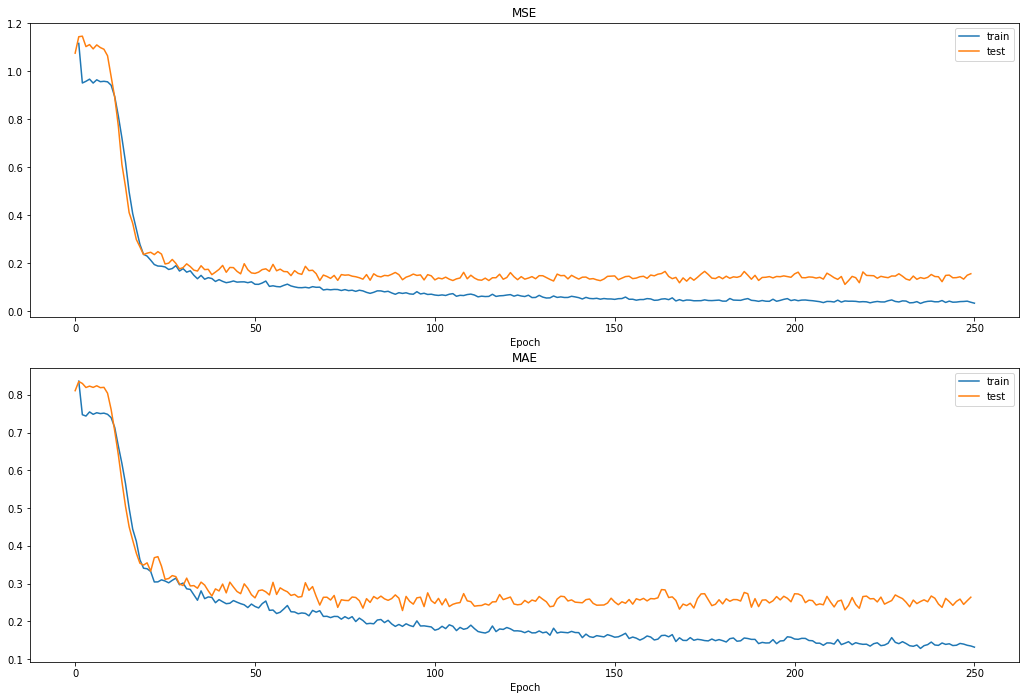

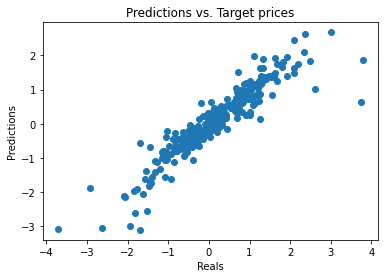

In [ ]:
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.Sigmoid()
third_model = Net(layer_sizes, activation_function)
optimizer = optim.Adam(third_model.parameters(), lr=0.002)
loss_function = nn.MSELoss()
other_metric = nn.L1Loss()
epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic, predicted_values, target_values = train_and_test(
    third_model, train_loader, test_loader, 
    epochs_num, optimizer, loss_function,
    other_metric)
plot_losses(epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic,
            epochs_num, "MSE", "MAE")
plot_pred_vs_target(predicted_values, target_values)

### Get MSE as loss function

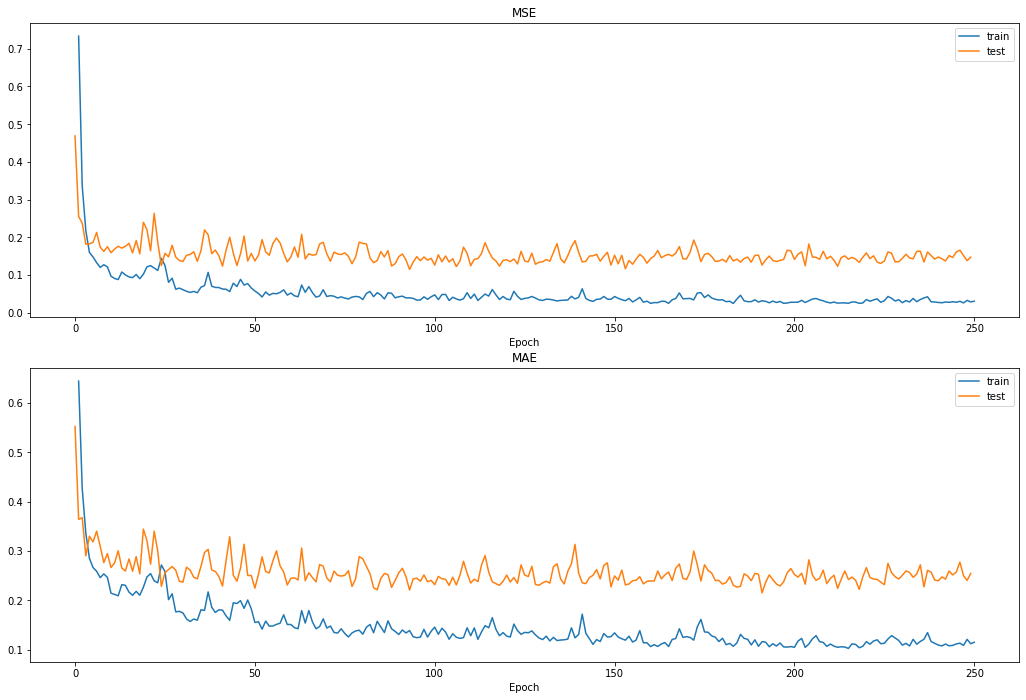

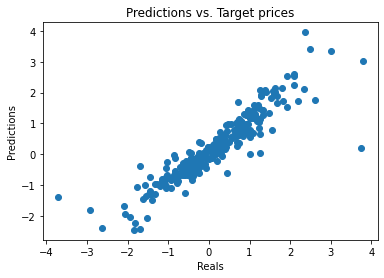

In [ ]:
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.ReLU()
base_model = Net(layer_sizes, activation_function)
optimizer = optim.Adam(base_model.parameters(), lr=0.002)
loss_function = nn.MSELoss()
other_metric = nn.L1Loss()
epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic, predicted_values, target_values = train_and_test(
    base_model, train_loader, test_loader, 
    epochs_num, optimizer, loss_function,
    other_metric)
plot_losses(epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic,
            epochs_num, "MSE", "MAE")
plot_pred_vs_target(predicted_values, target_values)

#### Find Best epoch

In [ ]:
def best_epoch(epochs_test_loss):
  raise_count = 0
  for index in range(len(epochs_test_loss)-1):
    if epochs_test_loss[index+1] >= epochs_test_loss[index]:
      raise_count += 1
    else:
      raise_count = max(raise_count-1, 0)
    if raise_count == 4:
      break
  print("Optimimum epochs count: {}".format(index))

best_epoch(epochs_test_loss)

Optimimum epochs count: 14


### Get MAE as loss function


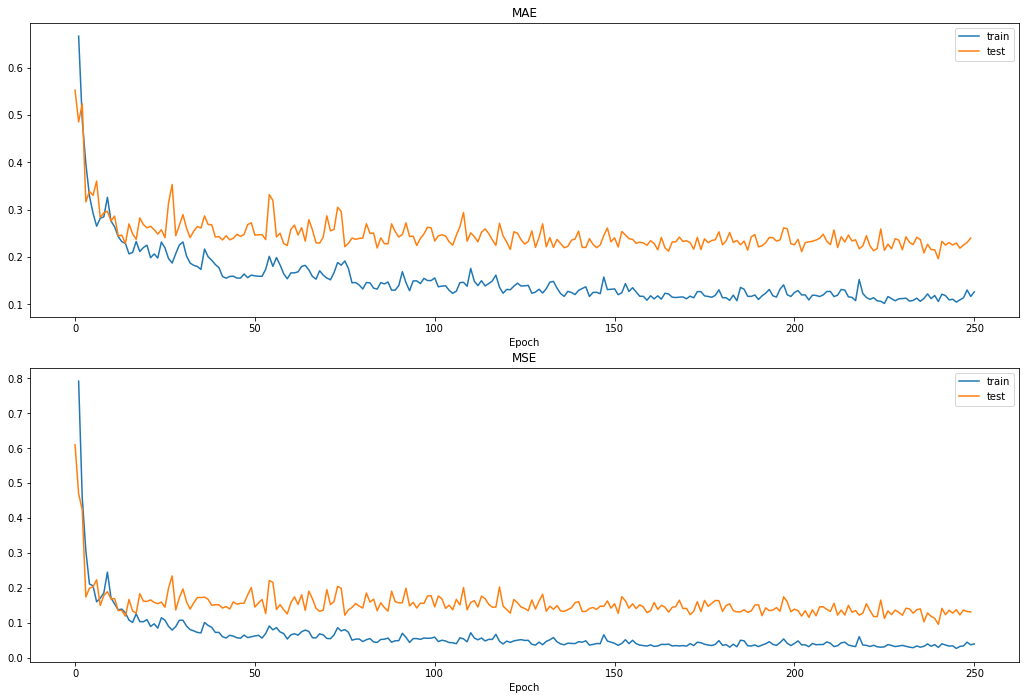

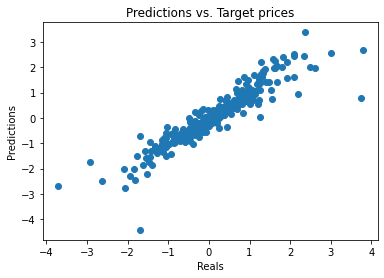

In [ ]:
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.ReLU()
base_model = Net(layer_sizes, activation_function)
optimizer = optim.Adam(base_model.parameters(), lr=0.002)
loss_function = nn.L1Loss()
other_metric = nn.MSELoss()
epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic, predicted_values, target_values = train_and_test(
    base_model, train_loader, test_loader, 
    epochs_num, optimizer, loss_function,
    other_metric)
plot_losses(epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic,
            epochs_num, "MAE", "MSE")
plot_pred_vs_target(predicted_values, target_values)

#### Find best epoch

In [ ]:
best_epoch(epochs_test_loss)

Optimimum epochs count: 48


## 2. MLP (Classification)

### Read, explore and Preprocess data

In [ ]:
sonar_file_path = "/content/sonar.all-data"
sonar_data = pd.read_csv(sonar_file_path, header=None)
sonar_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [ ]:
sonar_data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,0.324525,0.271750,0.231550,0.200375,0.154425,0.120100,0.0685

In [ ]:
sonar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       208 non-null    float64
 1   1       208 non-null    float64
 2   2       208 non-null    float64
 3   3       208 non-null    float64
 4   4       208 non-null    float64
 5   5       208 non-null    float64
 6   6       208 non-null    float64
 7   7       208 non-null    float64
 8   8       208 non-null    float64
 9   9       208 non-null    float64
 10  10      208 non-null    float64
 11  11      208 non-null    float64
 12  12      208 non-null    float64
 13  13      208 non-null    float64
 14  14      208 non-null    float64
 15  15      208 non-null    float64
 16  16      208 non-null    float64
 17  17      208 non-null    float64
 18  18      208 non-null    float64
 19  19      208 non-null    float64
 20  20      208 non-null    float64
 21  21      208 non-null    float64
 22  22

#### Normalize all columns except target column

In [ ]:
target_column = sonar_data.iloc[:,-1]
sonar_data.drop(sonar_data.columns[-1], axis=1, inplace=True)
normalized_sonar_data = (sonar_data - sonar_data.mean()) / sonar_data.std()
normalized_sonar_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,-0.398590,-0.040550,-0.026861,-0.713384,0.363579,-0.101009,0.520383,0.297126,1.122563,0.021135,-0.566016,-0.656956,-0.351196,-1.410969,-1.237431,-0.649845,-0.401943,-0.582796,0.011584,-0.317326,-0.119309,-0.457924,-0.856099,-0.492038,-0.017652,-0.246035,0.033564,0.480528,0.154114,-0.884387,-1.746676,-0.837755,0.459440,1.519912,1.779512,1.763784,1.272937,1.267965,0.846419,-0.206014,-1.392381,0.030266,0.258704,1.586942,0.440998,-0.164489,-0.199567,0.686931,-0.379064,0.876396,0.593850,-1.112747,-0.596166,0.679259,-0.294934,1.478069,1.759539,0.069702,0.171265,-0.657361
1,0.701845,0.420616,1.053078,0.322552,0.775804,2.600942,1.518961,2.504938,1.315152,0.587289,1.927492,2.891219,2.969555,2.937428,2.074698,2.432467,2.214894,1.663606,1.153496,0.832861,-0.340783,-0.856153,-1.004395,-1.176224,-1.430730,-1.601273,-1.526742,-1.759458,-0.831526,-1.712928,-0.587289,-0.676902,-1.059593,-0.731413,-1.010956,0.126277,0.082085,-1.098528,-0.712293,-0.639235,-0.712122,-1.303832,-0.765805,-0.384685,-0.891206,-1.047734,-0.798743,-0.275952,-0.306749,-1.048227,-0.297185,-0.521092,-0.256239,-0.841122,0.015466,1.896471,1.068155,-0.471269,-0.443484,-0.418842
2,-0.128918,0.599621,1.719257,1.169355,0.399581,2.088299,1.964032,2.845505,3.224987,3.058726,2.993770,3.253890,1.994116,1.431419,1.595208,1.352304,0.985739,1.157735,1.504287,1.137827,0.730515,0.193155,-0.870090,-1.287467,-0.581087,-1.933022,-0.794420,0.671515,-0.160142,1.225245,1.620265,0.306981,-1.118670,-0.572272,0.118198,-0.304965,1.032849,1.577394,1.063423,0.899428,1.025346,-0.116123,-0.242039,0.060957,0.091459,-1.067892,0.141998,-0.272748,-1.082741,-0.718919,-1.063310,1.015136,0.834360,-0.197357,1.228847,2.820442,4.110246,1.306209,0.252153,0.256962
3,-0.833544,-0.647348,0.480580,-0.717683,-0.984703,-1.146598,-0.193349,-0.084543,-0.998443,-0.609000,-1.114603,-0.364250,-1.808325,-0.428445,-0.717051,-0.710881,-1.314802,-0.857335,-0.383008,-0.631048,-1.299211,-0.997623,-0.365244,-0.786456,-1.475641,-0.701715,-0.718705,-1.863594,-1.802599,-1.019382,0.567892,1.383248,0.943187,-0.231503,0.010531,-0.316702,0.737741,2.543712,3.314840,3.389052,1.886775,1.317543,0.535696,0.796191,1.531822,1.528833,1.645114,1.060228,0.449774,0.656857,0.668797,-0.137035,-1.006911,0.555985,-0.111516,-0.160672,-0.487459,-0.548551,-0.637616,1.032149
4,2.045854,0.854476,0.111059,-0.311475,-0.291661,-0.671177,-0.013702,1.314129,1.506895,1.767954,1.350270,1.035031,1.080395,0.710942,0.645478,0.662426,1.193190,0.638482,-1.169090,-0.378624,-0.753477,-0.762360,-0.295693,-0.555187,-1.467067,-1.986978,-0.010807,1.290009,0.350160,-0.491634,0.027218,0.501131,-0.625238,-1.319543,-0.762048,0.125898,0.402619,-0.084317,-0.215997,-0.381765,-0.533875,-0.200875,-0.444926,-0.975122,-0.844381,-0.805084,-0.997702,-1.328555,-0.804608,-1.157997,-0.039035,-1.071228,-0.751966,-0.060386,0.241211,-1.171811,-0.107198,-0.486726,0.446284,0.574988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,-0.455134,-0.116400,-0.703449,-0.777861,-0.646283,0.988569,1.311800,0.406343,0.462864,0.447424,0.563560,0.307548,-0.324948,-1.198778,-0.682002,-0.681223,-0.541508,-0.635180,-1.168315,-1.481220,-0.760459,0.248649,0.659637,0.722016,0.883843,0.970096,1.207152,1.290009,0.700629,0.176545,0.465552,0.542400,-0.005906,-1.107211,-1.187313,-1.226891,-1.112517,-0.932310,-0.794675,-1.070218,-0.988550,-1.035353,-0.351397,-0.601504,-0.705885,-0.389220,0.340957,0.718973,0.942070,0.627585,0.352355,-0.188934,-0.128766,1.227143,-0.845189,0.327463,-0.228190,0.548848,1.837559,1.827213
204,0.136404,-0.859727,-0.365155,0.053896,0.014358,-0.148382,-0.368141,-0.387530,-0.633539,0.053125,0.546228,0.658796,0.182281,-0.950715,-0

#### Make target column binary (0, 1)

In [ ]:
target_binary_values = [1 if target=="M" else 0 for target in target_column]
normalized_sonar_data[60] = pd.Series(target_binary_values)
normalized_sonar_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,-0.398590,-0.040550,-0.026861,-0.713384,0.363579,-0.101009,0.520383,0.297126,1.122563,0.021135,-0.566016,-0.656956,-0.351196,-1.410969,-1.237431,-0.649845,-0.401943,-0.582796,0.011584,-0.317326,-0.119309,-0.457924,-0.856099,-0.492038,-0.017652,-0.246035,0.033564,0.480528,0.154114,-0.884387,-1.746676,-0.837755,0.459440,1.519912,1.779512,1.763784,1.272937,1.267965,0.846419,-0.206014,-1.392381,0.030266,0.258704,1.586942,0.440998,-0.164489,-0.199567,0.686931,-0.379064,0.876396,0.593850,-1.112747,-0.596166,0.679259,-0.294934,1.478069,1.759539,0.069702,0.171265,-0.657361,0
1,0.701845,0.420616,1.053078,0.322552,0.775804,2.600942,1.518961,2.504938,1.315152,0.587289,1.927492,2.891219,2.969555,2.937428,2.074698,2.432467,2.214894,1.663606,1.153496,0.832861,-0.340783,-0.856153,-1.004395,-1.176224,-1.430730,-1.601273,-1.526742,-1.759458,-0.831526,-1.712928,-0.587289,-0.676902,-1.059593,-0.731413,-1.010956,0.126277,0.082085,-1.098528,-0.712293,-0.639235,-0.712122,-1.303832,-0.765805,-0.384685,-0.891206,-1.047734,-0.798743,-0.275952,-0.306749,-1.048227,-0.297185,-0.521092,-0.256239,-0.841122,0.015466,1.896471,1.068155,-0.471269,-0.443484,-0.418842,0
2,-0.128918,0.599621,1.719257,1.169355,0.399581,2.088299,1.964032,2.845505,3.224987,3.058726,2.993770,3.253890,1.994116,1.431419,1.595208,1.352304,0.985739,1.157735,1.504287,1.137827,0.730515,0.193155,-0.870090,-1.287467,-0.581087,-1.933022,-0.794420,0.671515,-0.160142,1.225245,1.620265,0.306981,-1.118670,-0.572272,0.118198,-0.304965,1.032849,1.577394,1.063423,0.899428,1.025346,-0.116123,-0.242039,0.060957,0.091459,-1.067892,0.141998,-0.272748,-1.082741,-0.718919,-1.063310,1.015136,0.834360,-0.197357,1.228847,2.820442,4.110246,1.306209,0.252153,0.256962,0
3,-0.833544,-0.647348,0.480580,-0.717683,-0.984703,-1.146598,-0.193349,-0.084543,-0.998443,-0.609000,-1.114603,-0.364250,-1.808325,-0.428445,-0.717051,-0.710881,-1.314802,-0.857335,-0.383008,-0.631048,-1.299211,-0.997623,-0.365244,-0.786456,-1.475641,-0.701715,-0.718705,-1.863594,-1.802599,-1.019382,0.567892,1.383248,0.943187,-0.231503,0.010531,-0.316702,0.737741,2.543712,3.314840,3.389052,1.886775,1.317543,0.535696,0.796191,1.531822,1.528833,1.645114,1.060228,0.449774,0.656857,0.668797,-0.137035,-1.006911,0.555985,-0.111516,-0.160672,-0.487459,-0.548551,-0.637616,1.032149,0
4,2.045854,0.854476,0.111059,-0.311475,-0.291661,-0.671177,-0.013702,1.314129,1.506895,1.767954,1.350270,1.035031,1.080395,0.710942,0.645478,0.662426,1.193190,0.638482,-1.169090,-0.378624,-0.753477,-0.762360,-0.295693,-0.555187,-1.467067,-1.986978,-0.010807,1.290009,0.350160,-0.491634,0.027218,0.501131,-0.625238,-1.319543,-0.762048,0.125898,0.402619,-0.084317,-0.215997,-0.381765,-0.533875,-0.200875,-0.444926,-0.975122,-0.844381,-0.805084,-0.997702,-1.328555,-0.804608,-1.157997,-0.039035,-1.071228,-0.751966,-0.060386,0.241211,-1.171811,-0.107198,-0.486726,0.446284,0.574988,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,-0.455134,-0.116400,-0.703449,-0.777861,-0.646283,0.988569,1.311800,0.406343,0.462864,0.447424,0.563560,0.307548,-0.324948,-1.198778,-0.682002,-0.681223,-0.541508,-0.635180,-1.168315,-1.481220,-0.760459,0.248649,0.659637,0.722016,0.883843,0.970096,1.207152,1.290009,0.700629,0.176545,0.465552,0.542400,-0.005906,-1.107211,-1.187313,-1.226891,-1.112517,-0.932310,-0.794675,-1.070218,-0.988550,-1.035353,-0.351397,-0.601504,-0.705885,-0.389220,0.340957,0.718973,0.942070,0.627585,0.352355,-0.188934,-0.128766,1.227143,-0.845189,0.327463,-0.228190,0.548848,1.837559,1.827213,1
204,0.136404,-0.859727,-0.365155,0.053896,0.014358,-0.148382,-0.368141,-0.387530,-0.633539,0.053125,0.546228,0.658796,0.

### Split data to train, validation & test

In [ ]:
def get_train_val_test_loaders(dataset, train_percentage=0.8, 
                               validation_percentage=0.2, batch_size=64):
  target_column = dataset.columns[-1]
  target_tensor = torch.tensor(dataset[target_column].values)
  features_tensor = torch.tensor(dataset.drop(target_column, axis=1).values)
  tensor_dataset = torch.utils.data.TensorDataset(features_tensor, target_tensor)
  train_size = int(train_percentage * len(dataset))
  test_size = len(dataset) - train_size
  train_set, test_set = torch.utils.data.random_split(tensor_dataset, [train_size, test_size])
  validation_size = int(validation_percentage * train_size)
  train_size = train_size - validation_size
  train_set, validation_set = torch.utils.data.random_split(train_set, [train_size, validation_size])
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
  validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
  return train_loader, validation_loader, test_loader

train_set, validation_set, test_set = get_train_val_test_loaders(normalized_sonar_data)

### Define Network and training phase

In [ ]:
class SonarNet(nn.Module):
  def __init__(self, layer_sizes, activation_function):
    super().__init__()
    self.layers = nn.ModuleList()
    for layer_number in range(len(layer_sizes)-1):
      self.layers.append(nn.Linear(layer_sizes[layer_number], layer_sizes[layer_number+1]))
    self.activation_function = activation_function
    self.logsoftmax = nn.LogSoftmax(dim=1)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, input):
    input = input.view(input.shape[0], -1)
    for layer_number in range(len(self.layers)-1):
      inactive_layer_output = self.layers[layer_number](input)
      activated_output = self.activation_function(inactive_layer_output)
      input = self.dropout(activated_output)
    
    last_layer_output = self.layers[-1](input)
    output = self.sigmoid(last_layer_output)
    return output.squeeze(dim=1)

def train(model, train_set, validation_set, epochs_num, optimizer, loss_function):
  epochs_train_loss = []
  epochs_val_loss = []
  epochs_train_acc = []
  epochs_val_acc = []
  for epoch in range(epochs_num):
    batches_train_loss = []
    batches_train_predictions = []
    batches_train_targets = []
    batch_val_acc = []
    for features, targets in train_set:
      optimizer.zero_grad()
      output = model(features.float())
      loss = loss_function(output, targets.float())
      loss.backward()
      optimizer.step()
      batches_train_loss.append(loss.item())
      batches_train_predictions.append(torch.round(output))
      batches_train_targets.append(targets)
    batches_val_loss = []
    batches_val_predictions = []
    batches_val_targets = []
    with torch.no_grad():
      for features, target in validation_set:
        output = model(features.float())
        loss = loss_function(output, target.float()).item()
        batches_val_loss.append(loss)
        batches_val_predictions.append(torch.round(output))
        batches_val_targets.append(target)
      batches_train_predictions = list(np.concatenate(batches_train_predictions).flat)
      batches_train_targets = list(np.concatenate(batches_train_targets).flat)
      batches_val_predictions = list(np.concatenate(batches_val_predictions).flat)
      batches_val_targets = list(np.concatenate(batches_val_targets).flat)
    epochs_train_acc.append(accuracy_score(batches_train_targets, batches_train_predictions))
    epochs_val_acc.append(accuracy_score(batches_val_targets, batches_val_predictions))
    epochs_train_loss.append(np.mean(batches_train_loss))
    epochs_val_loss.append(np.mean(batches_val_loss))
  return epochs_train_loss, epochs_val_loss, epochs_train_acc, epochs_val_acc

In [ ]:
def plot_plots(epochs_train_loss, epochs_val_loss, epochs_num, title):
  x_axis = range(1, epochs_num+1)
  legends = ['train', 'validation']
  x_label = 'Epoch'
  plt.plot(x_axis, epochs_train_loss, epochs_val_loss)
  plt.title(title)
  plt.xlabel(x_label)
  plt.legend(legends)
  plt.show()

### Train Network

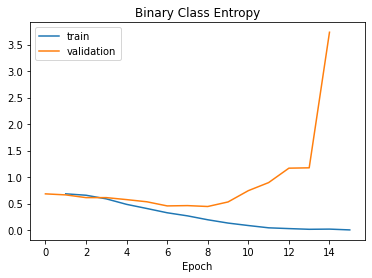

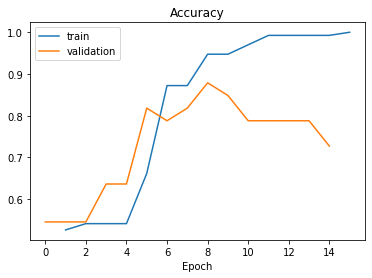

In [ ]:
epochs_num = 15
feature_size = normalized_sonar_data.shape[1]-1
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.ReLU()
base_model = SonarNet(layer_sizes, activation_function)
optimizer = optim.Adam(base_model.parameters(), lr=0.002)
loss_function = nn.BCELoss()
epochs_train_loss, epochs_val_loss, epochs_train_acc, epochs_val_acc = train(
    base_model, train_set, validation_set, epochs_num, optimizer, loss_function)
plot_plots(epochs_train_loss, epochs_val_loss, epochs_num, "Binary Class Entropy")
plot_plots(epochs_train_acc, epochs_val_acc, epochs_num, "Accuracy")

### Test Network

In [ ]:
batches_test_loss = []
batches_test_predictions = []
batches_test_targets = []
with torch.no_grad():
  for features, target in test_set:
    output = base_model(features.float())
    loss = loss_function(output, target.float()).item()
    batches_test_loss.append(loss)
    batches_test_predictions.append(torch.round(output))
    batches_test_targets.append(target)
  batches_test_predictions = list(np.concatenate(batches_test_predictions).flat)
  batches_test_targets = list(np.concatenate(batches_test_targets).flat)
accuracy = accuracy_score(batches_test_targets, batches_test_predictions)
print("Accuracy: {}".format(accuracy))
report = classification_report(batches_test_targets, batches_test_predictions)
print("Classificaiton report:\n{}".format(report))
print("Loss: {}".format(np.mean(batches_test_loss)))
conf_mat = confusion_matrix(batches_test_targets, batches_test_predictions)
print("Confusion Matrix:\n{}".format(conf_mat))

Accuracy: 0.9285714285714286
Classificaiton report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.88      1.00      0.93        21

    accuracy                           0.93        42
   macro avg       0.94      0.93      0.93        42
weighted avg       0.94      0.93      0.93        42

Loss: 0.21166428923606873
Confusion Matrix:
[[18  3]
 [ 0 21]]


### Train & Test with batch size = 32

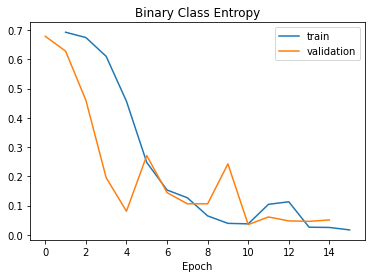

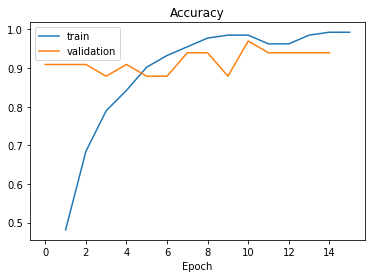

Accuracy: 0.9285714285714286
Classificaiton report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        25
           1       1.00      0.82      0.90        17

    accuracy                           0.93        42
   macro avg       0.95      0.91      0.92        42
weighted avg       0.94      0.93      0.93        42

Loss: 0.19308958668261766
Confusion Matrix:
[[25  0]
 [ 3 14]]


In [ ]:
train_set, validation_set, test_set = get_train_val_test_loaders(normalized_sonar_data,
                                                                 batch_size=32)
epochs_num = 15
feature_size = normalized_sonar_data.shape[1]-1
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.ReLU()
model1 = SonarNet(layer_sizes, activation_function)
optimizer = optim.Adam(model1.parameters(), lr=0.002)
loss_function = nn.BCELoss()
epochs_train_loss, epochs_val_loss, epochs_train_acc, epochs_val_acc = train(
    model1, train_set, validation_set, epochs_num, optimizer, loss_function)
plot_plots(epochs_train_loss, epochs_val_loss, epochs_num, "Binary Class Entropy")
plot_plots(epochs_train_acc, epochs_val_acc, epochs_num, "Accuracy")
batches_test_loss = []
batches_test_predictions = []
batches_test_targets = []
with torch.no_grad():
  for features, target in test_set:
    output = model1(features.float())
    loss = loss_function(output, target.float()).item()
    batches_test_loss.append(loss)
    batches_test_predictions.append(torch.round(output))
    batches_test_targets.append(target)
  batches_test_predictions = list(np.concatenate(batches_test_predictions).flat)
  batches_test_targets = list(np.concatenate(batches_test_targets).flat)
accuracy = accuracy_score(batches_test_targets, batches_test_predictions)
print("Accuracy: {}".format(accuracy))
report = classification_report(batches_test_targets, batches_test_predictions)
print("Classificaiton report:\n{}".format(report))
print("Loss: {}".format(np.mean(batches_test_loss)))
conf_mat = confusion_matrix(batches_test_targets, batches_test_predictions)
print("Confusion Matrix:\n{}".format(conf_mat))

### Train & Test with batch size = 128

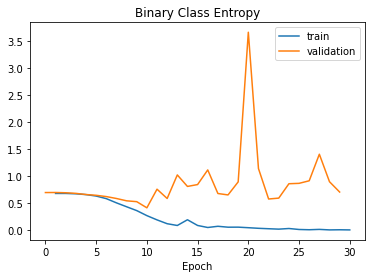

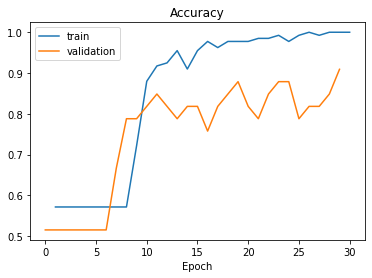

Accuracy: 0.9047619047619048
Classificaiton report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        24
           1       0.94      0.83      0.88        18

    accuracy                           0.90        42
   macro avg       0.91      0.90      0.90        42
weighted avg       0.91      0.90      0.90        42

Loss: 0.6666709780693054
Confusion Matrix:
[[23  1]
 [ 3 15]]


In [ ]:
train_set, validation_set, test_set = get_train_val_test_loaders(normalized_sonar_data,
                                                                 batch_size=128)
epochs_num = 30
feature_size = normalized_sonar_data.shape[1]-1
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.ReLU()
model1 = SonarNet(layer_sizes, activation_function)
optimizer = optim.Adam(model1.parameters(), lr=0.002)
loss_function = nn.BCELoss()
epochs_train_loss, epochs_val_loss, epochs_train_acc, epochs_val_acc = train(
    model1, train_set, validation_set, epochs_num, optimizer, loss_function)
plot_plots(epochs_train_loss, epochs_val_loss, epochs_num, "Binary Class Entropy")
plot_plots(epochs_train_acc, epochs_val_acc, epochs_num, "Accuracy")
batches_test_loss = []
batches_test_predictions = []
batches_test_targets = []
with torch.no_grad():
  for features, target in test_set:
    output = model1(features.float())
    loss = loss_function(output, target.float()).item()
    batches_test_loss.append(loss)
    batches_test_predictions.append(torch.round(output))
    batches_test_targets.append(target)
  batches_test_predictions = list(np.concatenate(batches_test_predictions).flat)
  batches_test_targets = list(np.concatenate(batches_test_targets).flat)
accuracy = accuracy_score(batches_test_targets, batches_test_predictions)
print("Accuracy: {}".format(accuracy))
report = classification_report(batches_test_targets, batches_test_predictions)
print("Classificaiton report:\n{}".format(report))
print("Loss: {}".format(np.mean(batches_test_loss)))
conf_mat = confusion_matrix(batches_test_targets, batches_test_predictions)
print("Confusion Matrix:\n{}".format(conf_mat))

### Train & Test with activation function = sigmoid

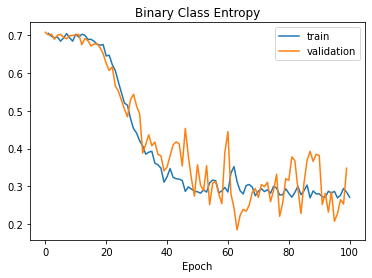

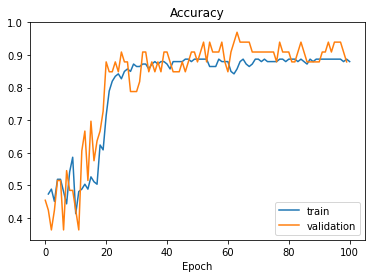

Accuracy: 0.7380952380952381
Classificaiton report:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        19
           1       0.75      0.78      0.77        23

    accuracy                           0.74        42
   macro avg       0.74      0.73      0.73        42
weighted avg       0.74      0.74      0.74        42

Loss: 0.764928936958313
Confusion Matrix:
[[13  6]
 [ 5 18]]


In [ ]:
train_set, validation_set, test_set = get_train_val_test_loaders(normalized_sonar_data)
epochs_num = 100
feature_size = normalized_sonar_data.shape[1]-1
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.Sigmoid()
model1 = SonarNet(layer_sizes, activation_function)
optimizer = optim.Adam(model1.parameters(), lr=0.002)
loss_function = nn.BCELoss()
epochs_train_loss, epochs_val_loss, epochs_train_acc, epochs_val_acc = train(
    model1, train_set, validation_set, epochs_num, optimizer, loss_function)
plot_plots(epochs_train_loss, epochs_val_loss, epochs_num, "Binary Class Entropy")
plot_plots(epochs_train_acc, epochs_val_acc, epochs_num, "Accuracy")
batches_test_loss = []
batches_test_predictions = []
batches_test_targets = []
with torch.no_grad():
  for features, target in test_set:
    output = model1(features.float())
    loss = loss_function(output, target.float()).item()
    batches_test_loss.append(loss)
    batches_test_predictions.append(torch.round(output))
    batches_test_targets.append(target)
  batches_test_predictions = list(np.concatenate(batches_test_predictions).flat)
  batches_test_targets = list(np.concatenate(batches_test_targets).flat)
accuracy = accuracy_score(batches_test_targets, batches_test_predictions)
print("Accuracy: {}".format(accuracy))
report = classification_report(batches_test_targets, batches_test_predictions)
print("Classificaiton report:\n{}".format(report))
print("Loss: {}".format(np.mean(batches_test_loss)))
conf_mat = confusion_matrix(batches_test_targets, batches_test_predictions)
print("Confusion Matrix:\n{}".format(conf_mat))

### Train & Test with activation function = tanh

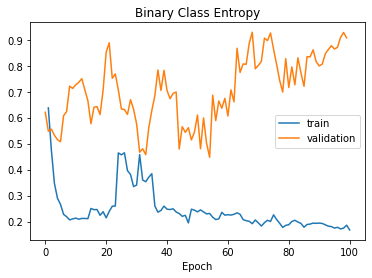

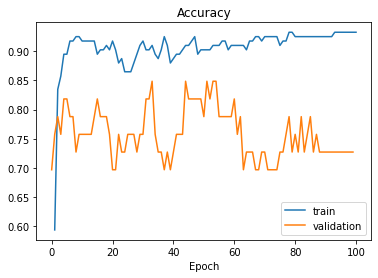

Accuracy: 0.7142857142857143
Classificaiton report:
              precision    recall  f1-score   support

           0       0.65      0.85      0.74        20
           1       0.81      0.59      0.68        22

    accuracy                           0.71        42
   macro avg       0.73      0.72      0.71        42
weighted avg       0.74      0.71      0.71        42

Loss: 0.8308720588684082
Confusion Matrix:
[[17  3]
 [ 9 13]]


In [ ]:
train_set, validation_set, test_set = get_train_val_test_loaders(normalized_sonar_data)
epochs_num = 100
feature_size = normalized_sonar_data.shape[1]-1
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.Tanh()
model1 = SonarNet(layer_sizes, activation_function)
optimizer = optim.Adam(model1.parameters(), lr=0.002)
loss_function = nn.BCELoss()
epochs_train_loss, epochs_val_loss, epochs_train_acc, epochs_val_acc = train(
    model1, train_set, validation_set, epochs_num, optimizer, loss_function)
plot_plots(epochs_train_loss, epochs_val_loss, epochs_num, "Binary Class Entropy")
plot_plots(epochs_train_acc, epochs_val_acc, epochs_num, "Accuracy")
batches_test_loss = []
batches_test_predictions = []
batches_test_targets = []
with torch.no_grad():
  for features, target in test_set:
    output = model1(features.float())
    loss = loss_function(output, target.float()).item()
    batches_test_loss.append(loss)
    batches_test_predictions.append(torch.round(output))
    batches_test_targets.append(target)
  batches_test_predictions = list(np.concatenate(batches_test_predictions).flat)
  batches_test_targets = list(np.concatenate(batches_test_targets).flat)
accuracy = accuracy_score(batches_test_targets, batches_test_predictions)
print("Accuracy: {}".format(accuracy))
report = classification_report(batches_test_targets, batches_test_predictions)
print("Classificaiton report:\n{}".format(report))
print("Loss: {}".format(np.mean(batches_test_loss)))
conf_mat = confusion_matrix(batches_test_targets, batches_test_predictions)
print("Confusion Matrix:\n{}".format(conf_mat))

### Train & Test with adding layer

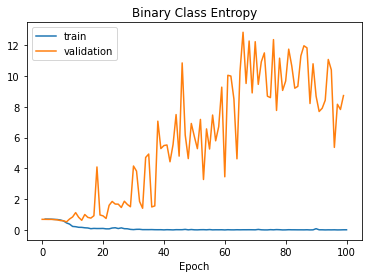

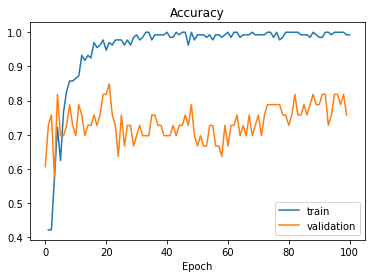

Accuracy: 0.8809523809523809
Classificaiton report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.84      0.92        32

    accuracy                           0.88        42
   macro avg       0.83      0.92      0.86        42
weighted avg       0.92      0.88      0.89        42

Loss: 2.6612601280212402
Confusion Matrix:
[[10  0]
 [ 5 27]]


In [ ]:
train_set, validation_set, test_set = get_train_val_test_loaders(normalized_sonar_data)
epochs_num = 100
feature_size = normalized_sonar_data.shape[1]-1
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 8, 4, 1]
activation_function = nn.ReLU()
model1 = SonarNet(layer_sizes, activation_function)
optimizer = optim.Adam(model1.parameters(), lr=0.002)
loss_function = nn.BCELoss()
epochs_train_loss, epochs_val_loss, epochs_train_acc, epochs_val_acc = train(
    model1, train_set, validation_set, epochs_num, optimizer, loss_function)
plot_plots(epochs_train_loss, epochs_val_loss, epochs_num, "Binary Class Entropy")
plot_plots(epochs_train_acc, epochs_val_acc, epochs_num, "Accuracy")
batches_test_loss = []
batches_test_predictions = []
batches_test_targets = []
with torch.no_grad():
  for features, target in test_set:
    output = model1(features.float())
    loss = loss_function(output, target.float()).item()
    batches_test_loss.append(loss)
    batches_test_predictions.append(torch.round(output))
    batches_test_targets.append(target)
  batches_test_predictions = list(np.concatenate(batches_test_predictions).flat)
  batches_test_targets = list(np.concatenate(batches_test_targets).flat)
accuracy = accuracy_score(batches_test_targets, batches_test_predictions)
print("Accuracy: {}".format(accuracy))
report = classification_report(batches_test_targets, batches_test_predictions)
print("Classificaiton report:\n{}".format(report))
print("Loss: {}".format(np.mean(batches_test_loss)))
conf_mat = confusion_matrix(batches_test_targets, batches_test_predictions)
print("Confusion Matrix:\n{}".format(conf_mat))

### Train & Test with lower layer and neurons

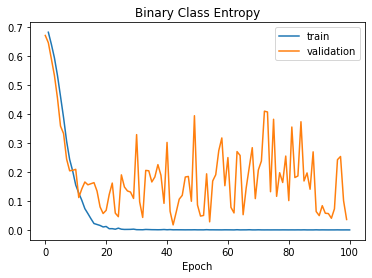

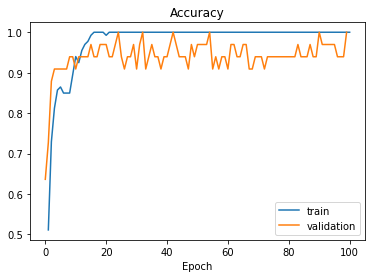

Accuracy: 0.8333333333333334
Classificaiton report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80        19
           1       0.81      0.91      0.86        23

    accuracy                           0.83        42
   macro avg       0.84      0.82      0.83        42
weighted avg       0.84      0.83      0.83        42

Loss: 1.4825496673583984
Confusion Matrix:
[[14  5]
 [ 2 21]]


In [ ]:
train_set, validation_set, test_set = get_train_val_test_loaders(normalized_sonar_data)
epochs_num = 100
feature_size = normalized_sonar_data.shape[1]-1
layer_sizes = [feature_size, 200, 50, 20, 1]
activation_function = nn.ReLU()
model1 = SonarNet(layer_sizes, activation_function)
optimizer = optim.Adam(model1.parameters(), lr=0.002)
loss_function = nn.BCELoss()
epochs_train_loss, epochs_val_loss, epochs_train_acc, epochs_val_acc = train(
    model1, train_set, validation_set, epochs_num, optimizer, loss_function)
plot_plots(epochs_train_loss, epochs_val_loss, epochs_num, "Binary Class Entropy")
plot_plots(epochs_train_acc, epochs_val_acc, epochs_num, "Accuracy")
batches_test_loss = []
batches_test_predictions = []
batches_test_targets = []
with torch.no_grad():
  for features, target in test_set:
    output = model1(features.float())
    loss = loss_function(output, target.float()).item()
    batches_test_loss.append(loss)
    batches_test_predictions.append(torch.round(output))
    batches_test_targets.append(target)
  batches_test_predictions = list(np.concatenate(batches_test_predictions).flat)
  batches_test_targets = list(np.concatenate(batches_test_targets).flat)
accuracy = accuracy_score(batches_test_targets, batches_test_predictions)
print("Accuracy: {}".format(accuracy))
report = classification_report(batches_test_targets, batches_test_predictions)
print("Classificaiton report:\n{}".format(report))
print("Loss: {}".format(np.mean(batches_test_loss)))
conf_mat = confusion_matrix(batches_test_targets, batches_test_predictions)
print("Confusion Matrix:\n{}".format(conf_mat))

## 3. Dimension Reduction

### Draw correlation matrix for house pricing data

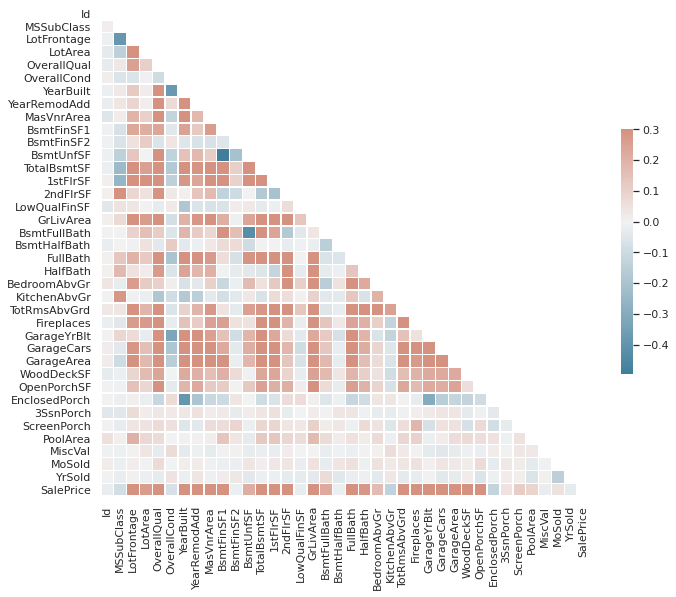

In [ ]:
sns.set_theme(style="white")
correlation_matrix = housing_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Linear Regression Feature Importance on housing data

In [ ]:
target_column = "SalePrice"
target = housing_data[target_column]
features = housing_data.drop(target_column, axis=1)
regressor = LinearRegression()
regressor.fit(features, target)
intercept = regressor.intercept_
features_importance = pd.DataFrame(regressor.coef_, features.columns, columns=['coefficient'])
features_importance.coefficient = features_importance.coefficient.abs()
features_importance

,coefficient
MSSubClass,4.206025e-02
LotArea,7.658826e-02
OverallQual,1.424917e-01
OverallCond,1.021999e-01
YearBuilt,1.246984e-01
...,...
x42_2.5Fin,1.335548e+09
x42_2.5Unf,1.335548e+09
x42_2Story,1.335548e+09
x42_SFoyer,1.335548e+09


#### Make features importance scale same

In [ ]:
stdevs = []
for i in features.columns:
    stdev = features[i].std()
    stdevs.append(stdev)
 
features_importance["stdev"] = np.array(stdevs).reshape(-1,1)
features_importance["importance"] = features_importance["coefficient"] * features_importance["stdev"]
features_importance['importance_normalized'] = 100*features_importance['importance'] / features_importance['importance'].max()
features_importance.sort_values(by=['importance_normalized'], inplace=True, ascending=False)
features_importance

,coefficient,stdev,importance,importance_normalized
1stFlrSF,2.216567e+10,0.460478,1.020681e+10,1.000000e+02
TotalBsmtSF,1.714789e+10,0.500164,8.576756e+09,8.402976e+01
GrLivArea,3.012932e+10,0.206319,6.216259e+09,6.090307e+01
2ndFlrSF,2.502911e+10,0.157217,3.934999e+09,3.855270e+01
x28_Unf,6.983804e+09,0.397021,2.772714e+09,2.716534e+01
...,...,...,...,...
MiscVal,6.589277e-03,1.000000,6.589277e-03,6.455767e-11
OpenPorchSF,5.115821e-03,1.000000,5.115821e-03,5.012166e-11
MasVnrArea,4.208650e-03,1.000000,4.208650e-03,4.123376e-11
MoSold,3.407954e-03,1.000000,3.407954e-03,3.338903e-11


#### Plot normalized importance of most important features as bar plot

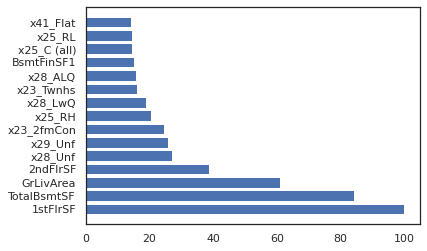

In [ ]:
most_important_features = features_importance.iloc[:15,:]
plt.barh(most_important_features.index, most_important_features.importance_normalized)
plt.show()

### Decision Tree Feature Importance on housing data

In [ ]:
target_column = "SalePrice"
target = housing_data[target_column]
features = housing_data.drop(target_column, axis=1)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(features, target)
feature_coefs = regressor.feature_importances_
features_importance = pd.DataFrame(feature_coefs, features.columns, columns=['importance'])
features_importance['importance_normalized'] = 100*features_importance['importance'] / features_importance['importance'].max()
features_importance.sort_values(by=['importance_normalized'], inplace=True, ascending=False)
features_importance

,importance,importance_normalized
OverallQual,0.564884,100.000000
GrLivArea,0.132882,23.523773
TotalBsmtSF,0.069964,12.385582
YearBuilt,0.021023,3.721584
BsmtFinSF1,0.019541,3.459264
...,...,...
x26_Basment,0.000000,0.000000
x26_CarPort,0.000000,0.000000
x27_Ex,0.000000,0.000000
x28_No,0.000000,0.000000


#### Plot most important features as bar plot

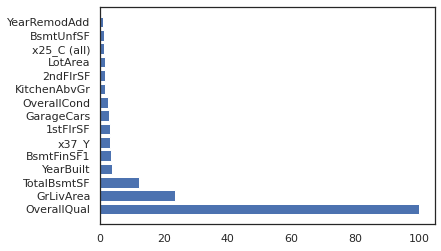

In [ ]:
most_important_features = features_importance.iloc[:15,:]
plt.barh(most_important_features.index, most_important_features.importance_normalized)
plt.show()

### Backward elimination

In [ ]:
target_column = "SalePrice"
target = housing_data[target_column]
features = housing_data.drop(target_column, axis=1)
significance_level = 0.05
removed_features_count = 0
start_time = time.time()
while True:
  columns = features.columns
  regressor = sm.OLS(target, features).fit()
  max_p_value = max(regressor.pvalues)
  if max_p_value < significance_level:
    break
  removed_features_count += 1
  max_p_value_column_index = np.argmax(regressor.pvalues)
  column_to_remove = columns[max_p_value_column_index]
  features.drop(column_to_remove, axis=1, inplace=True)
  print("Feature {} has been removed with p value: {}".format(column_to_remove, max_p_value))
end_time = time.time()
spent_time = end_time - start_time
print("{} features has been removed.".format(removed_features_count))
print("Elapsed time: {} Seconds".format(spent_time))

Feature x21_AsphShn has been removed with p value: 0.999665000835541
Feature x21_WdShing has been removed with p value: 0.9979810577843669
Feature x17_Unf has been removed with p value: 0.9925351033257934
Feature x20_SWISU has been removed with p value: 0.9888589831192437
Feature x38_GasA has been removed with p value: 0.9882807550604731
Feature x2_CWD has been removed with p value: 0.9793752441550578
Feature x2_Oth has been removed with p value: 0.9887894496635677
Feature x5_Ex has been removed with p value: 0.9703536087279605
Feature x36_Basment has been removed with p value: 0.9644012684264088
Feature x20_Timber has been removed with p value: 0.9594974003970299
Feature x14_1.5Unf has been removed with p value: 0.9545397637236587
Feature x36_Attchd has been removed with p value: 0.9545037449834679
Feature x6_Brk Cmn has been removed with p value: 0.9450556776415031
Feature x6_ImStucc has been removed with p value: 0.9908730801474632
Feature x12_Po has been removed with p value: 0.929

#### Train Net on reduced features

Train and test time: 20.85078763961792 seconds


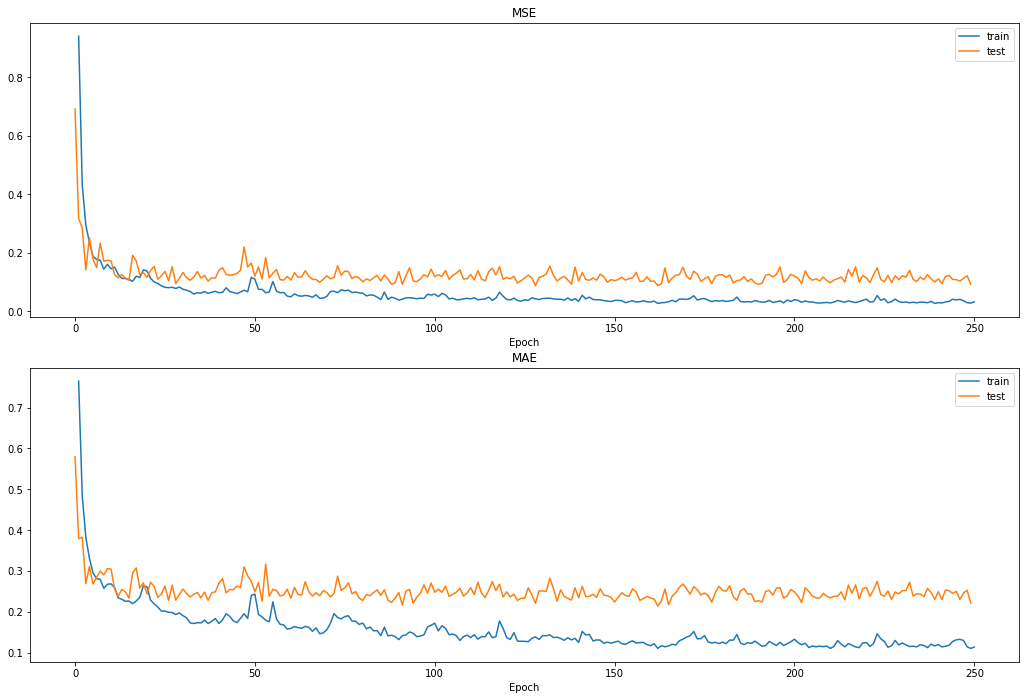

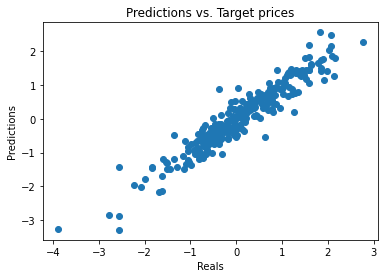

Minimum MSE: 0.08712012444933255


In [ ]:
epochs_num = 250
features[target_column] = target
train_loader, test_loader = get_train_test_loaders(features, target_column)
feature_size = features.shape[1]-1
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.ReLU()
base_model = Net(layer_sizes, activation_function)
optimizer = optim.Adam(base_model.parameters(), lr=0.002)
loss_function = nn.MSELoss()
other_metric = nn.L1Loss()
start_time = time.time()
epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic, predicted_values, target_values = train_and_test(
    base_model, train_loader, test_loader, 
    epochs_num, optimizer, loss_function,
    other_metric)
end_time = time.time()
print("Train and test time: {} seconds".format(end_time-start_time))
plot_losses(epochs_train_loss, epochs_train_metric, epochs_test_loss, epochs_test_metic,
            epochs_num, "MSE", "MAE")
plot_pred_vs_target(predicted_values, target_values)
print("Minimum MSE: {}".format(min(epochs_test_loss)))

### Dimension Reduction with PCA
#### + Train & Test SonarNet

(208, 50)
PCA & Train time: 1.7040863037109375 seconds


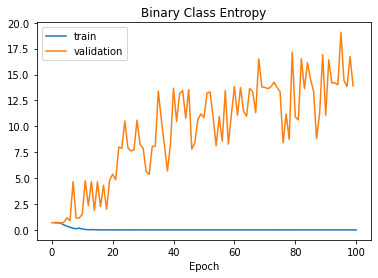

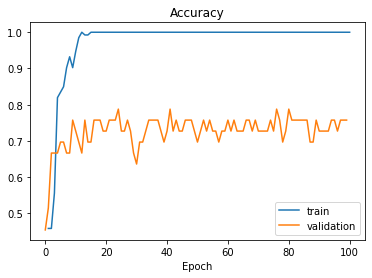

Test Accuracy: 0.9285714285714286
Classificaiton report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.91      0.95      0.93        21

    accuracy                           0.93        42
   macro avg       0.93      0.93      0.93        42
weighted avg       0.93      0.93      0.93        42

Loss: 0.4035155475139618
Confusion Matrix:
[[19  2]
 [ 1 20]]
Total time: 2.0610265731811523 seconds


In [ ]:
def PCA_func(X, y):
  pca = PCA(n_components=50, random_state=0)
  pca.fit(X, y)
  reduced_X = pca.transform(X)
  return reduced_X

start_time = time.time()
target_column = normalized_sonar_data.columns[-1]
target = normalized_sonar_data[target_column]
features = normalized_sonar_data.drop(target_column, axis=1)
reduced_features = PCA_func(features, target)
print(reduced_features.shape)

features_dataframe = pd.DataFrame(reduced_features)
features_dataframe[50] = pd.DataFrame(target)
train_set, validation_set, test_set = get_train_val_test_loaders(features_dataframe)

epochs_num = 100
feature_size = reduced_features.shape[1]
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.ReLU()
base_model = SonarNet(layer_sizes, activation_function)
optimizer = optim.Adam(base_model.parameters(), lr=0.002)
loss_function = nn.BCELoss()
epochs_train_loss, epochs_val_loss, epochs_train_acc, epochs_val_acc = train(
    base_model, train_set, validation_set, epochs_num, optimizer, loss_function)
end_time = time.time()
print("PCA & Train time: {} seconds".format(end_time - start_time))
plot_plots(epochs_train_loss, epochs_val_loss, epochs_num, "Binary Class Entropy")
plot_plots(epochs_train_acc, epochs_val_acc, epochs_num, "Accuracy")
batches_test_loss = []
batches_test_predictions = []
batches_test_targets = []
with torch.no_grad():
  for features, target in test_set:
    output = base_model(features.float())
    loss = loss_function(output, target.float()).item()
    batches_test_loss.append(loss)
    batches_test_predictions.append(torch.round(output))
    batches_test_targets.append(target)
  batches_test_predictions = list(np.concatenate(batches_test_predictions).flat)
  batches_test_targets = list(np.concatenate(batches_test_targets).flat)
accuracy = accuracy_score(batches_test_targets, batches_test_predictions)
print("Test Accuracy: {}".format(accuracy))
report = classification_report(batches_test_targets, batches_test_predictions)
print("Classificaiton report:\n{}".format(report))
print("Loss: {}".format(np.mean(batches_test_loss)))
conf_mat = confusion_matrix(batches_test_targets, batches_test_predictions)
print("Confusion Matrix:\n{}".format(conf_mat))
end_time = time.time()
print("Total time: {} seconds".format(end_time - start_time))

### Dimension Reduction with Auto Encoder
#### + Train & Test SonarNet

Epoch 1/50
24/24 [==============================] - 1s 16ms/step - loss: 0.6762 - val_loss: 0.5367
Epoch 2/50
24/24 [==============================] - 0s 4ms/step - loss: 0.4285 - val_loss: 0.3641
Epoch 3/50
24/24 [==============================] - 0s 4ms/step - loss: 0.1346 - val_loss: 0.1264
Epoch 4/50
24/24 [==============================] - 0s 4ms/step - loss: -0.1768 - val_loss: -0.1701
Epoch 5/50
24/24 [==============================] - 0s 4ms/step - loss: -0.7296 - val_loss: -0.5336
Epoch 6/50
24/24 [==============================] - 0s 4ms/step - loss: -1.2260 - val_loss: -0.9738
Epoch 7/50
24/24 [==============================] - 0s 4ms/step - loss: -1.8495 - val_loss: -1.4219
Epoch 8/50
24/24 [==============================] - 0s 4ms/step - loss: -2.4827 - val_loss: -2.0705
Epoch 9/50
24/24 [==============================] - 0s 4ms/step - loss: -3.7697 - val_loss: -2.8608
Epoch 10/50
24/24 [==============================] - 0s 4ms/step - loss: -5.1685 - val_loss: -3.7812
Epoc

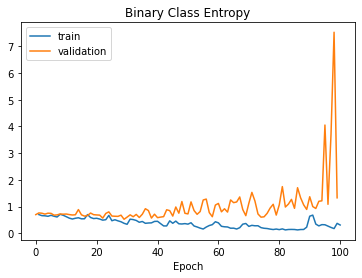

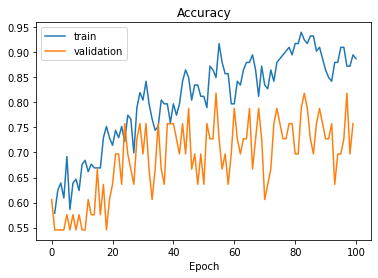

Test Accuracy: 0.7857142857142857
Classificaiton report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        23
           1       0.78      0.74      0.76        19

    accuracy                           0.79        42
   macro avg       0.78      0.78      0.78        42
weighted avg       0.79      0.79      0.79        42

Loss: 0.6531055569648743
Confusion Matrix:
[[19  4]
 [ 5 14]]
Total time: 7.930836200714111 seconds


In [ ]:
def AutoEncoder(X, y):
  encoding_dim = 50
  input_data = Input(shape=(X.shape[1],))
  encoded = Dense(encoding_dim, activation='relu')(input_data)
  decoded = Dense(X.shape[1], activation='sigmoid')(encoded)
  autoencoder = Model(input_data, decoded)
  autoencoder.compile(optimizer='adam',
                      loss='binary_crossentropy')
  
  hist_auto = autoencoder.fit(X, X,
                  epochs=50,
                  batch_size=8,
                  shuffle=True,
                  validation_split=0.1)
  encoder = Model(input_data, encoded)
  encoded_input = Input(shape=(encoding_dim,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(encoded_input, decoder_layer(encoded_input))
  encoded_X = encoder.predict(X)
  return encoded_X

start_time = time.time()
target_column = normalized_sonar_data.columns[-1]
target = normalized_sonar_data[target_column]
features = normalized_sonar_data.drop(target_column, axis=1)
reduced_features = AutoEncoder(features, target)
print(reduced_features.shape)
features_dataframe = pd.DataFrame(reduced_features)
features_dataframe[50] = pd.DataFrame(target)
train_set, validation_set, test_set = get_train_val_test_loaders(features_dataframe)

epochs_num = 100
feature_size = reduced_features.shape[1]
layer_sizes = [feature_size, 512, 256, 128, 64, 32, 16, 1]
activation_function = nn.ReLU()
base_model = SonarNet(layer_sizes, activation_function)
optimizer = optim.Adam(base_model.parameters(), lr=0.002)
loss_function = nn.BCELoss()
epochs_train_loss, epochs_val_loss, epochs_train_acc, epochs_val_acc = train(
    base_model, train_set, validation_set, epochs_num, optimizer, loss_function)
end_time = time.time()
print("Autoencoding & Train time: {} seconds".format(end_time - start_time))
plot_plots(epochs_train_loss, epochs_val_loss, epochs_num, "Binary Class Entropy")
plot_plots(epochs_train_acc, epochs_val_acc, epochs_num, "Accuracy")
batches_test_loss = []
batches_test_predictions = []
batches_test_targets = []
with torch.no_grad():
  for features, target in test_set:
    output = base_model(features.float())
    loss = loss_function(output, target.float()).item()
    batches_test_loss.append(loss)
    batches_test_predictions.append(torch.round(output))
    batches_test_targets.append(target)
  batches_test_predictions = list(np.concatenate(batches_test_predictions).flat)
  batches_test_targets = list(np.concatenate(batches_test_targets).flat)
accuracy = accuracy_score(batches_test_targets, batches_test_predictions)
print("Test Accuracy: {}".format(accuracy))
report = classification_report(batches_test_targets, batches_test_predictions)
print("Classificaiton report:\n{}".format(report))
print("Loss: {}".format(np.mean(batches_test_loss)))
conf_mat = confusion_matrix(batches_test_targets, batches_test_predictions)
print("Confusion Matrix:\n{}".format(conf_mat))
end_time = time.time()
print("Total time: {} seconds".format(end_time - start_time))